In [22]:
!pip install tensorflow_probability

In [23]:
#import the necessary packages
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Flatten, Dropout, Dense
from google.colab.patches import cv2_imshow
from scipy.optimize import minimize

In [24]:
# disable the interactive logging progress bar
tf.keras.utils.disable_interactive_logging()

Define CNN architecture

In [25]:
class SimpleCNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # first CONV => RELU => BN layer set
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # second CONV => RELU => BN layer set
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

Define L-BFGS architecture

In [26]:
# [dataset_type] 0:cifar10, 1:cifar100
# [model_type] 0:DNN, 1:CNN
class LBFGS():
  def __init__(self, dataset_type=0, model_type=1, name='abc'):
    self.dataset_type = dataset_type
    self.model_type = model_type
    # CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck:
    self.labels_cifar10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    self.name = name
    self.Initialize()

  def Initialize(self):
    self.load_dataset()
    self.data_preprocessing()
    self.build_model()

  def load_dataset(self):
    if self.dataset_type == 0:
      print("[INFO] loading CIFAR-10 dataset...")
      (self.trainX, self.trainY), (self.testX, self.testY) = cifar10.load_data()

  def data_preprocessing(self):
    self.trainX = self.trainX / 255.0
    self.testX = self.testX / 255.0
    # add a channel dimension to the images
    self.trainX = np.expand_dims(self.trainX, axis=-1)
    self.testX = np.expand_dims(self.testX, axis=-1)
    # one-hot encode our labels
    self.trainY = to_categorical(self.trainY, 10)
    self.testY = to_categorical(self.testY, 10)

  def build_model(self):
    if self.dataset_type == 0:
      self.model = SimpleCNN.build(width=32, height=32, depth=3, classes=10) # define our model

    print("[INFO] compiling model...")
    self.opt = Adam(learning_rate=1e-3) # initial learning rate

    # prepare model for fitting (loss, optimizer, metrics)
    self.model.compile(loss='categorical_crossentropy',
                           optimizer=self.opt,
                           metrics=['accuracy']) # report accuracy during training

  def train_evaluate_model(self, epochs=10, batch_size=64):
      print("[INFO] training network...")
      # fit model
      self.model.fit(self.trainX, self.trainY, # prepared data
                     validation_data=(self.testX, self.testY),batch_size=batch_size, epochs=epochs, verbose=1)

      # evaluate model
      print("[INFO] evaluating network...")
      (loss, acc) = self.model.evaluate(x=self.testX, y=self.testY, verbose=0)
      print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

  def generate_image_adversary(self, image, label, eps=0.01 / 255.0):
        def loss(x):
        # convert the image to a TensorFlow tensor
          image2 = tf.cast(x.reshape(image.shape), tf.float32)
          # use our model to make predictions on the input image and then compute the loss
          pred = self.model(image2)
          loss = tf.keras.losses.categorical_crossentropy(tf.expand_dims(label, axis=0), pred).numpy().astype(np.float64)
          return loss

        def gradient(x):
          # convert the image to a TensorFlow tensor
          image2 = tf.cast(x.reshape(image.shape), tf.float32)
          # record our gradients
          with tf.GradientTape() as tape:

            # explicitly indicate that our image should be tracked for gradient updates
            tape.watch(image2) # track changes to the input image
            pred = self.model(image2) # predict the label of the input image
            loss = tf.keras.losses.categorical_crossentropy(tf.expand_dims(label, axis=0), pred)

          return tape.gradient(loss, image2).numpy().flatten().astype(np.float64) # compute the gradient of the loss with respect to the input image

        # perform L-BFGS optimization
        res = minimize(fun=loss, x0=image.flatten(), jac=gradient, method='L-BFGS-B', options={'maxiter': 200})

        # return the adversarial example
        return res.x.reshape(image.shape)

  def generate_image_adversary_targeted(self, image, target, eps=0.01 / 255.0):

        target = target.reshape(1, 10)
        target = tf.convert_to_tensor(target, dtype=tf.float32) # convert the target label to a TensorFlow tensor

        # define the loss function
        def loss(x):
        # convert the image to a TensorFlow tensor
          image2 = tf.cast(x.reshape(image.shape), tf.float32)
          # use our model to make predictions on the input image and then compute the loss
          pred = self.model(image2)
          loss = -tf.keras.losses.categorical_crossentropy(tf.expand_dims(target, axis=0), pred).numpy().astype(np.float64)
          return loss

        def gradient(x):
          # convert the image to a TensorFlow tensor
          image2 = tf.cast(x.reshape(image.shape), tf.float32)
          # record our gradients
          with tf.GradientTape() as tape:

            # explicitly indicate that our image should be tracked for gradient updates
            tape.watch(image2) # track changes to the input image
            pred = self.model(image2) # predict the label of the input image
            loss = tf.keras.losses.categorical_crossentropy(tf.expand_dims(target, axis=0), pred)

          return tape.gradient(loss, image2).numpy().flatten().astype(np.float64) # compute the gradient of the loss with respect to the input image

        # perform L-BFGS optimization
        res = minimize(fun=loss, x0=image.flatten(), jac=gradient, method='L-BFGS-B', options={'maxiter': 200})

        # return the adversarial example
        return res.x.reshape(image.shape)

  # set the maximum number of iterations to prevent infinite repetitions
  def my_generator(self, max_iterations=30, targeted=False, target=None):

        # loop over a sample of our testing images
        for i in np.random.choice(np.arange(0, len(self.testX)), size=(10,)):
            # grab the image and label
            image = self.testX[i]
            label = self.testY[i]
            adversary = image.reshape(1, 32, 32, 3)
            iteration = 0

            if targeted:
                if target is None:
                    raise ValueError("target must be provided for a targeted attack.")
                target = to_categorical([target], num_classes=10)
                target = tf.convert_to_tensor(target, dtype=tf.float32)

            while iteration < max_iterations:
                # generate the adversarial example
                if targeted:
                    adversary = self.generate_image_adversary_targeted(adversary, target, eps=0.1)
                else:
                    adversary = self.generate_image_adversary(adversary, label, eps=0.1)

                pred = self.model.predict(adversary) # predict the label of the adversarial example
                adversaryPred = pred[0].argmax()

                 # if the prediction is correct (non-targeted) or matches the target label (targeted), break the loop
                if (not targeted and adversaryPred != label.argmax()) or (targeted and adversaryPred == target):
                    break

                # otherwise, increment the iteration
                iteration += 1

            # scale both the original image and adversary to the range [0, 255]
            adversary = adversary.reshape((32, 32, 3)) * 255
            adversary = np.clip(adversary, 0, 255).astype("uint8")
            image = image.reshape((32, 32, 3)) * 255
            image = image.astype("uint8") # convert to an unsigned 8-bit integers

            # convert the image and adversarial image from grayscale to three channel

            # resize the images so we can better visualize them
            image = cv2.resize(image, (96, 96))
            adversary = cv2.resize(adversary, (96, 96))

            # determine the predicted label for both the original image and adversarial image

            # get the index of the class with the highest probability
            imagePred = label.argmax()
            adversaryPred = pred[0].argmax()
            color = (0, 255, 0) # green
            if imagePred != adversaryPred: # if the prediction is incorrect, set the color to red
               color = (0, 0, 255)

            # draw the predictions on the respective output images
            cv2.putText(image, str(imagePred), (2, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
            cv2.putText(adversary, str(adversaryPred), (2, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

            # stack the two images horizontally and then show the original image and adversarial image
            output = np.hstack([image, adversary])
            cv2_imshow(output) # imports the function cv2_imshow instead of cv2.imshow in Google Colab
            cv2.waitKey(0)

  def run(self):
        self.build_model
        self.train_evaluate_model()
        self.my_generator()

Generate adversarial examples by calling L-BFGS

[INFO] loading CIFAR-10 dataset...
[INFO] compiling model...
[INFO] loading CIFAR-10 dataset...
[INFO] compiling model...
[INFO] training network...
[INFO] evaluating network...
[INFO] loss: 1.0092, acc: 0.6686


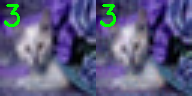

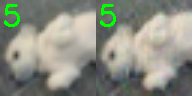

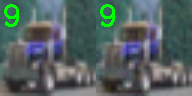

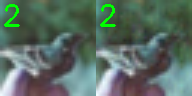

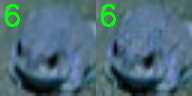

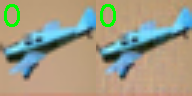

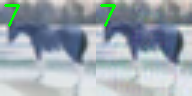

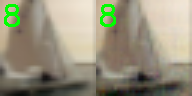

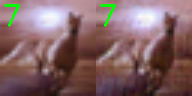

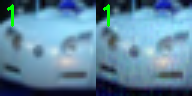

In [21]:
result = LBFGS(name='test')
result.Initialize()
result.run()